In [2]:
# libs
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from scipy import misc
import glob
import random
import cv2
from sklearn.model_selection import train_test_split

# useful functions 
def save_image_set_txt(path, index):
    f = open(path, 'w')
    for ind in index:
        f.write(ind+'\n')
    f.close()

In [18]:
# read annotations from txt files to DataFrame
ann_path = '../datasets/final/annotations/'
# ann_path = '../datasets/CALTECH/annotations/'
true_bboxs = []

for vid_set in sorted(os.listdir(ann_path)):
    for vid in sorted(os.listdir(ann_path+vid_set)):
        for i, k in enumerate(sorted(os.listdir(ann_path+vid_set+'/' + vid))):
            filename = ann_path+vid_set+'/' +vid + '/' + k
            # check if annotation is empy
            if os.stat(filename).st_size > 0:
                f = open(filename,"r")                
                info = f.readlines()
                for bbox in info:
                    splitted = bbox.split(' ')
                    im_id = k[:-4]
                    cls = splitted[0]
                    x = splitted[1]
                    y = splitted[2]
                    width = splitted[3]
                    height = splitted[4]
                    occluded = splitted[5]
                    # KAIST reasonable configuration (not occluded, visible extent and more than 55 px)
                    if int(height)>=55 and int(occluded)==0:
                        true_bboxs.append([vid_set+'-'+vid+'-'+im_id, cls, x, y, width, height])
data = pd.DataFrame(true_bboxs, columns=['INDEX', 'CLS', 'X', 'Y', 'W', 'H'])   
data = data[data.CLS.isin(['person'])]

print 'unique images', len(data.INDEX.unique())

unique images 7061


In [20]:
dataset = 'kaist'

if dataset == 'caltech':    
    extension = '.jpg'
    draw_results = False
    dataset_path='../datasets/CALTECH/images/'

#     train_sets  = ['set00', 'set01', 'set02', 'set03', 'set04', 'set05']
#     test_sets = ['set06', 'set07', 'set08', 'set09', 'set10']
    train_sets = ['set00', 'set01', 'set02', 'set03', 'set04', 'set05', 'set06', 'set07', 'set08', 'set09', 'set10']
    
elif dataset == 'kaist':
    extension = '.png'
    draw_results = True
    dataset_path = '../datasets/final/images/'
    
    train_sets = ['set00', 'set01', 'set02', 'set03', 'set04', 'set05']
    test_sets  = ['set06', 'set07', 'set08', 'set09', 'set10', 'set11']
    test_day_sets = ['set06', 'set07', 'set08']
    test_night_sets = ['set09', 'set10', 'set11']
    
converted_dataset_folder = os.path.join(os.getcwd(), dataset)
conv_images_path = os.path.join(converted_dataset_folder, 'images')    
conv_annotations = os.path.join(converted_dataset_folder, 'annotations') 
conv_img_sets = os.path.join(converted_dataset_folder, 'image_sets') 
figures = os.path.join(converted_dataset_folder, 'bbox_pictures') 

image_set_train = os.path.join(converted_dataset_folder, 'image_sets', 'train.txt')
image_set_val = os.path.join(converted_dataset_folder, 'image_sets', 'val.txt')
image_set_test  = os.path.join(converted_dataset_folder, 'image_sets', 'test.txt') 
image_set_test_day  = os.path.join(converted_dataset_folder, 'image_sets', 'test_day.txt')
image_set_test_night  = os.path.join(converted_dataset_folder, 'image_sets', 'test_night.txt')

if not os.path.exists(converted_dataset_folder):
    os.makedirs(converted_dataset_folder)
    os.makedirs(conv_images_path)
    os.makedirs(conv_annotations)
    os.makedirs(conv_img_sets)
    os.makedirs(figures)
    
train_index = []
test_index = []
test_day_index = []
test_night_index = []

for ind, INDEX in enumerate(data.INDEX.unique()):
    # find all notes with this index
    index_data = data[data.INDEX == INDEX]
    vid_set, vid, IM_ID = INDEX.split('-')
    
    if vid_set in train_sets:
        train_index.append(dataset+INDEX)        
    elif vid_set in test_sets:
        test_index.append(dataset+INDEX)
        if vid_set in test_day_sets:
            test_day_index.append(dataset+INDEX)
        elif vid_set in test_night_sets:
            test_night_index.append(dataset+INDEX)
    
    image = misc.imread((dataset_path + vid_set + '/' + vid +'/' + IM_ID + extension))
    
    if dataset == 'caltech':
        misc.imsave(conv_images_path + '/'+ dataset + INDEX + extension, image)
        
        if draw_results:
            rgb = image[:,:,:3].copy()
    
    if dataset == 'kaist': 
        # save image in dataset images_folder
        misc.imsave(conv_images_path + '/'+ dataset+INDEX + '.jpg', image[:,:,:3])
#         np.save(conv_images_path + '/' + dataset + INDEX, image[:,:,:3] )
        
        if draw_results and ind%100==0:
            #split data to RGB and TIR for visualization
            rgb = image[:,:,:3].copy()
            tir = image[:,:,3].copy()


    # add basic annotations info     
    f = open(conv_annotations + '/' + dataset + INDEX + '.xml','w')
    line = "<annotation>" + '\n'
    f.write(line)
    line = '\t\t<folder>' + "folder" + '</folder>' + '\n'
    f.write(line)
    line = '\t\t<filename>' + dataset + INDEX + '</filename>' + '\n'
    f.write(line)
    line = '\t\t<source>\n\t\t<database>Source</database>\n\t</source>\n'
    f.write(line)
    (width, height) = image.shape[0], image.shape[1]
    line = '\t<size>\n\t\t<width>'+ str(width) + '</width>\n\t\t<height>' + str(height) + '</height>\n\t'
    line += '\t<depth>3</depth>\n\t</size>'
    f.write(line)
    line = '\n\t<segmented>Unspecified</segmented>'
    f.write(line)

    # get annotations only for this picture
    for idx, row in index_data.iterrows():    
        x=int(row[2])
        y=int(row[3])
        w=int(row[4])
        h=int(row[5])
        line = '\n\t<object>'
        line += '\n\t\t<name>'+row[1]+'</name>\n\t\t<pose>Unspecified</pose>'
        line += '\n\t\t<truncated>Unspecified</truncated>\n\t\t<difficult>0</difficult>'
        line += '\n\t\t<bndbox>\n\t\t\t<xmin>' + str(x) + '</xmin>'            
        line += '\n\t\t\t<ymin>' + str(y) + '</ymin>'
        line += '\n\t\t\t<xmax>' + str(x+w) + '</xmax>'
        line += '\n\t\t\t<ymax>' + str(y+h) + '</ymax>'
        line += '\n\t\t</bndbox>'
        line += '\n\t</object>\n' 
        f.write(line) 

        if draw_results and ind%100==0:
            if dataset == 'caltech':
                cv2.rectangle(rgb,(x,y),(x+w,y+h),(0,255,0),2)

            if dataset == 'kaist':
                cv2.rectangle(rgb,(x,y),(x+w,y+h),(0,255,0),2)
                cv2.rectangle(tir,(x,y),(x+w,y+h),(0,255,0),2) 

    line = "</annotation>" + '\n'
    f.write(line)
    f.close()

    if draw_results and dataset=='caltech' and ind%100==0:
        plt.figure(figsize=(10,10))
        plt.axis('off')
        plt.imshow(rgb)
        plt.tight_layout()
        plt.savefig(figures+ '/'+INDEX+extension)
        plt.close()

    if draw_results and dataset=='kaist' and ind%100==0:
        # create/save figures with thermal-rgb pairs
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 20))
        ax = axes.ravel()
        ax[0].imshow(rgb)
        ax[0].set_title('RGB')
        ax[0].axis('off')
        ax[1].imshow(tir, cmap=plt.get_cmap('Spectral_r'))
        ax[1].set_title('TIR')
        ax[1].axis('off')
        fig.tight_layout()
        fig.savefig(figures+ '/'+INDEX+extension)
        plt.close(fig)

# save current image sets
save_image_set_txt(image_set_train, train_index)
save_image_set_txt(image_set_test, test_index) 
save_image_set_txt(image_set_test_day, test_day_index)
save_image_set_txt(image_set_test_night, test_night_index)

# print info
print 'train_img: ', len(train_index)
print 'test_img:', len(test_index)
print 'test_day_img', len(test_day_index)
print 'test_night_img', len(test_night_index)

train_img:  6660
test_img: 401
test_day_img 274
test_night_img 127


In [22]:
# calculate mean for training set
mean_pixel_r = []
mean_pixel_g = []
mean_pixel_b = []
mean_pixel_tir = []

for i, name in enumerate(os.listdir('../mxnet-ssd/data/custom/images/')):
    if name[:-4] in train_index:
        image_rgb = misc.imread(('../mxnet-ssd/data/custom/images/'+name))
#         image_rgb = np.load((conv_images_path+'/'+name))
        mean_pixel_r.append(image_rgb[:,:,0].mean())
        mean_pixel_g.append(image_rgb[:,:,1].mean())
        mean_pixel_b.append(image_rgb[:,:,2].mean())
#         mean_pixel_tir.append(image_rgb.mean())
        
# print pixel values
print 'R: ', np.array(mean_pixel_r).mean()
print 'G: ', np.array(mean_pixel_g).mean()
print 'B: ', np.array(mean_pixel_b).mean()
# print 'T: ', np.array(mean_pixel_tir).mean()

R:  89.8327051542
G:  83.8860213179
B:  73.830072669


In [45]:
image = misc.imread((dataset_path + vid_set + '/' + vid +'/' + IM_ID + extension))

In [51]:
a = cv2.imread((dataset_path + vid_set + '/' + vid +'/' + IM_ID + extension), 0)

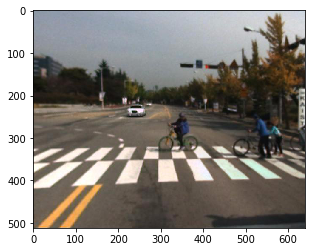

In [139]:
plt.imshow(image_rgb)

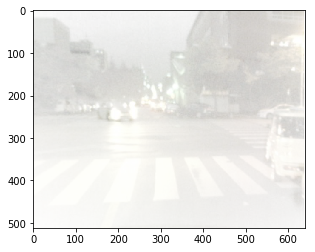

In [58]:
plt.imshow(image, cmap='gray')

In [85]:
import mxnet as mx

In [86]:
with open(conv_images_path +'/' + INDEX + '.npy', 'rb') as fp:
    img_content = fp.read()
img = mx.img.imdecode(img_content)
# m = cv2.imread(img_content, 0)

In [83]:
plt.imshow(img.asnumpy(), cmap='gray')

KeyError: -1

In [115]:
kaist_train = train_index

In [122]:
caltech_train = train_index

In [128]:
final_set = kaist_train + caltech_train

In [129]:
save_image_set_txt(image_set_train, final_set)